# 🧠 Classificação e Segmentação de Imagens de Ultrassom da Mama
Usando VGG-16 (classificação) e U-Net (segmentação) com o dataset do Kaggle.

In [1]:
%pip install tensorflow opencv-python scikit-learn matplotlib kaggle

Note: you may need to restart the kernel to use updated packages.


## 📥 Download do Dataset via Kaggle API

In [2]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
breast-ultrasound-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import os, zipfile

os.environ['KAGGLE_CONFIG_DIR'] = '.'

with zipfile.ZipFile("breast-ultrasound-images-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("breast_ultrasound_dataset")

print("✅ Dataset baixado e extraído com sucesso!")


✅ Dataset baixado e extraído com sucesso!


## 📁 Importação de Bibliotecas

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
%pip install scikit-image scipy

from preprocessing_pipeline import UltrasoundPreprocessor, preprocess_batch, demonstrate_preprocessing
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure
from scipy import ndimage
from skimage.feature import canny

# Instância global do pré-processador
preprocessor = UltrasoundPreprocessor(target_size=(224, 224))

print("✅ Pipeline de pré-processamento carregado com sucesso!")

Note: you may need to restart the kernel to use updated packages.
✅ Pipeline de pré-processamento carregado com sucesso!


## Demonstração do pipeline

🔧 Demonstração do Pipeline de Pré-processamento


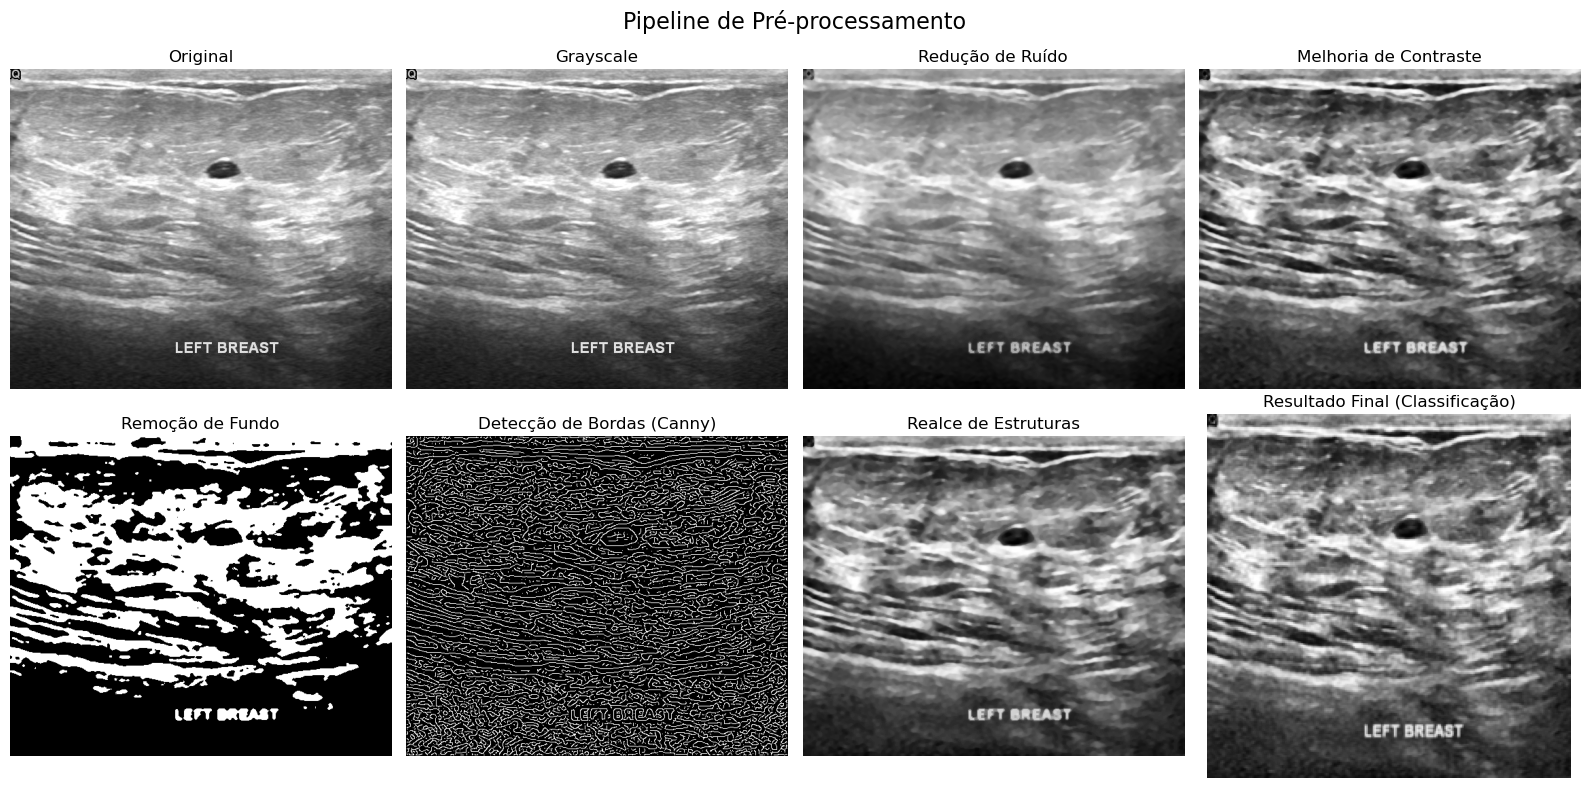


📊 Resultados do Pré-processamento:


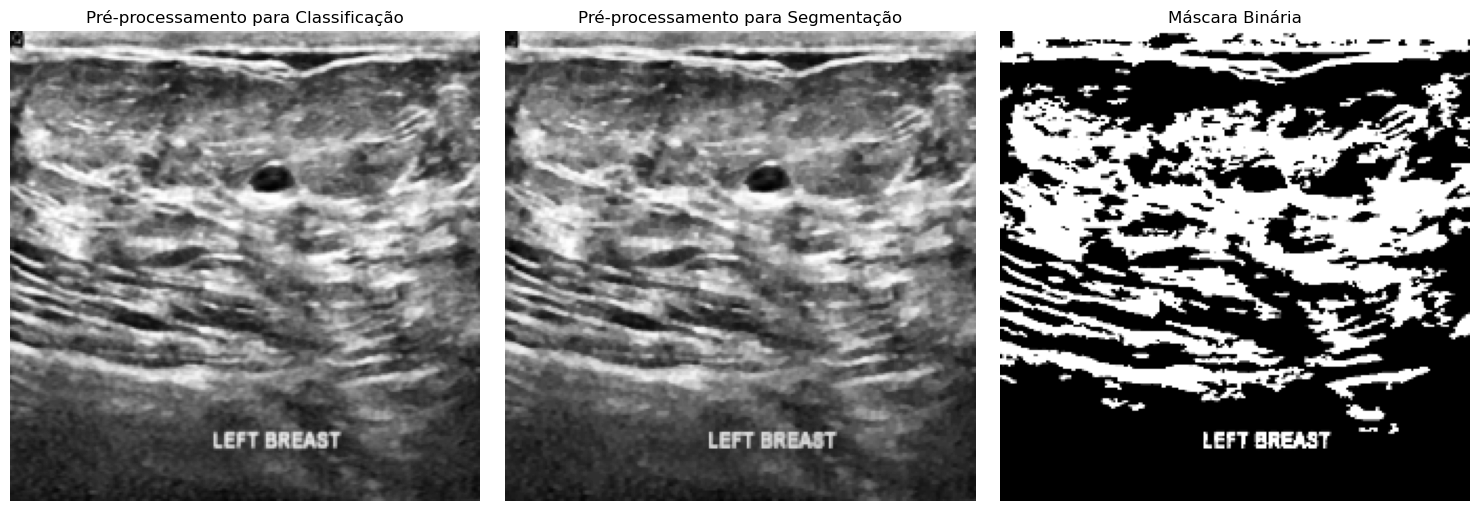

✅ Demonstração concluída!


In [6]:
sample_image_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
demonstrate_preprocessing(sample_image_path)

## 🗂️ Carregamento e Pré-processamento para Classificação

In [7]:
base_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/'
classes = ['benign', 'malignant', 'normal']
img_size = 224

X = []
y = []

print("🔄 Carregando e pré-processando imagens para classificação...")

for idx, label in enumerate(classes):
    folder = os.path.join(base_path, label)
    print(f"   Processando classe: {label}")
    
    for filename in os.listdir(folder):
        if 'mask' not in filename:
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            
            # Aplica pré-processamento otimizado para classificação
            processed_img = preprocessor.preprocess_for_classification(
                img,
                apply_grayscale=True,
                apply_noise_reduction=True,
                apply_contrast=True,
                apply_background_removal=False,  # Opcional para classificação
                apply_edge_detection=False       # Opcional para classificação
            )
            
            # Converte para 3 canais se necessário para VGG-16
            if len(processed_img.shape) == 2:
                processed_img = np.stack([processed_img] * 3, axis=-1)
            
            X.append(processed_img)
            y.append(idx)

X = np.array(X)
y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"✅ Dataset carregado: {len(X)} imagens, {len(classes)} classes")
print(f"   Treino: {len(X_train)} imagens")
print(f"   Teste: {len(X_test)} imagens")

🔄 Carregando e pré-processando imagens para classificação...
   Processando classe: benign
   Processando classe: malignant
   Processando classe: normal
✅ Dataset carregado: 780 imagens, 3 classes
   Treino: 624 imagens
   Teste: 156 imagens


## 🧠 Modelo VGG-16 para Classificação

In [8]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in vgg.layers:
    layer.trainable = False

x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model_class = Model(inputs=vgg.input, outputs=predictions)
model_class.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_class.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 📊 Treinamento do Modelo de Classificação

In [9]:
model_class.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=16)

Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.4915 - loss: 1.0707 - val_accuracy: 0.5577 - val_loss: 0.9202
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.6033 - loss: 0.8805 - val_accuracy: 0.6154 - val_loss: 0.8657
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.6192 - loss: 0.8603 - val_accuracy: 0.6218 - val_loss: 0.8047
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - accuracy: 0.6898 - loss: 0.7554 - val_accuracy: 0.6795 - val_loss: 0.7714
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.6627 - loss: 0.7887 - val_accuracy: 0.6859 - val_loss: 0.7794


In [10]:
loss, accuracy = model_class.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.6878 - loss: 0.7951
Test Loss: 0.7794
Test Accuracy: 0.6859


In [ ]:
history = model_class.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=16
)

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title("Evolução da Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = model_class.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
correct = np.where(y_pred_classes == y_true)[0]
incorrect = np.where(y_pred_classes != y_true)[0]

def plot_examples(indices, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:3]):
        plt.subplot(1, 3, i+1)
        plt.imshow(X_test[idx])
        plt.title(f"Pred: {classes[y_pred_classes[idx]]}\nReal: {classes[y_true[idx]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_examples(correct, "Exemplos Corretos")
plot_examples(incorrect, "Exemplos Incorretos")

## 🖼️ Função para Carregar Imagens e Máscaras (Segmentação)

In [16]:
def load_images_and_masks(base_path, classes=('benign', 'malignant'), img_size=(256, 256)):
    img_list, mask_list, label_list = [], [], []
    
    from preprocessing_pipeline import UltrasoundPreprocessor
    preprocessor = UltrasoundPreprocessor(target_size=img_size)

    for class_name in classes:
        folder = os.path.join(base_path, class_name)
        print(f"�� Carregando imagens e máscaras para {class_name}...")
        
        for fname in os.listdir(folder):
            if 'mask' in fname.lower():
                continue
            img_path = os.path.join(folder, fname)
            mask_path = os.path.join(folder, fname.split('.')[0] + '_mask.png')
            if not os.path.exists(mask_path): 
                continue

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                continue

            # Pré-processamento
            processed_img = preprocessor.preprocess_for_segmentation(
                img,
                apply_grayscale=True,
                apply_noise_reduction=True,
                apply_contrast=True,
                apply_structure_enhancement=True
            )
            
            # Converte grayscale para 3 canais (RGB)
            if len(processed_img.shape) == 2:
                processed_img = np.stack([processed_img] * 3, axis=-1)
            
            # Redimensiona
            processed_img = cv2.resize(processed_img, img_size)
            
            # Processa máscara
            mask = cv2.resize(mask, img_size).astype('float32') / 255.0
            mask = np.expand_dims(mask, axis=-1)

            img_list.append(processed_img)
            mask_list.append(mask)
            label_list.append(class_name)
        
        print(f"   ✅ {len([x for x in label_list if x == class_name])} imagens processadas")

    return np.array(img_list), np.array(mask_list), np.array(label_list)

## 📥 Carregamento dos Dados de Segmentação

In [17]:
X_seg, y_seg, labels_seg = load_images_and_masks(base_path, img_size=(256, 256))

X_train_seg, X_val_seg, y_train_seg, y_val_seg = train_test_split(
    X_seg, y_seg, test_size=0.2, random_state=42, stratify=labels_seg)

�� Carregando imagens e máscaras para benign...
   ✅ 437 imagens processadas
�� Carregando imagens e máscaras para malignant...
   ✅ 210 imagens processadas


## 🧬 Modelo U-Net para Segmentação

In [18]:
def build_model(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
    encoder_output = base_model.output

    x = Conv2DTranspose(256, (3,3), strides=(2,2), padding="same")(encoder_output)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2DTranspose(128, (3,3), strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2DTranspose(64, (3,3), strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2DTranspose(32, (3,3), strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2DTranspose(16, (3,3), strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    outputs = Conv2D(1, (1,1), activation="sigmoid")(x)

    return Model(inputs, outputs)

model_seg = build_model()
model_seg.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model_seg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 7,392,868 (28.20 MB)

 Trainable params: 7,349,853 (28.04 MB)

 Non-trainable params: 43,015 (168.03 KB)

## 🧪 Treinamento do Modelo de Segmentação

In [19]:
history = model_seg.fit(
    X_train_seg, y_train_seg,
    validation_data=(X_val_seg, y_val_seg),
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.6967 - loss: 0.6367 - val_accuracy: 0.8934 - val_loss: 0.6777
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.9212 - loss: 0.4720 - val_accuracy: 0.9034 - val_loss: 0.6520
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9485 - loss: 0.3755 - val_accuracy: 0.9071 - val_loss: 0.6160
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9558 - loss: 0.3239 - val_accuracy: 0.9032 - val_loss: 0.5799
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9609 - loss: 0.2914 - val_accuracy: 0.9004 - val_loss: 0.5437
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9619 - loss: 0.2740 - val_accuracy: 0.9083 - val_loss: 0.4912
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.9669 - loss: 0.2564 - val_accuracy: 0.9045 - val_loss: 0.4585
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9697 - loss: 0.2435 - val_accuracy: 0.9053 - val_loss

## 🔍 Visualização de Resultados de Segmentação

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 789ms/step


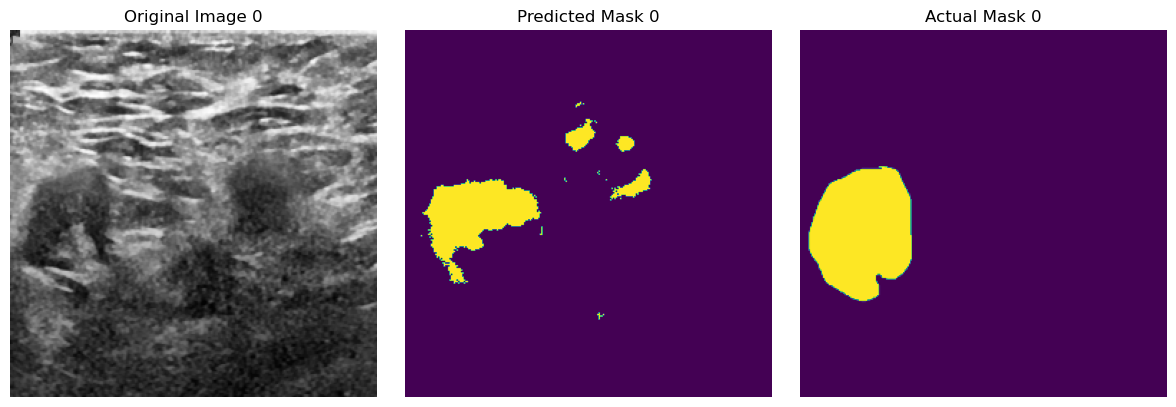

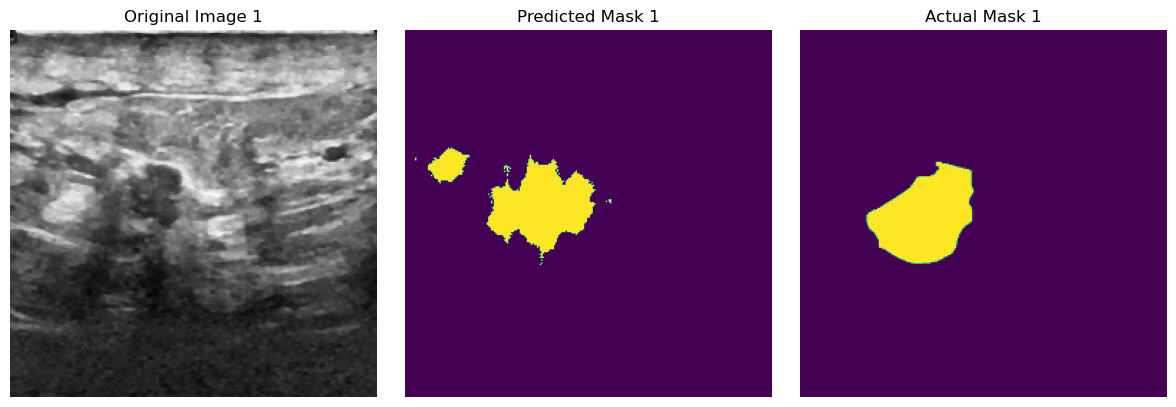

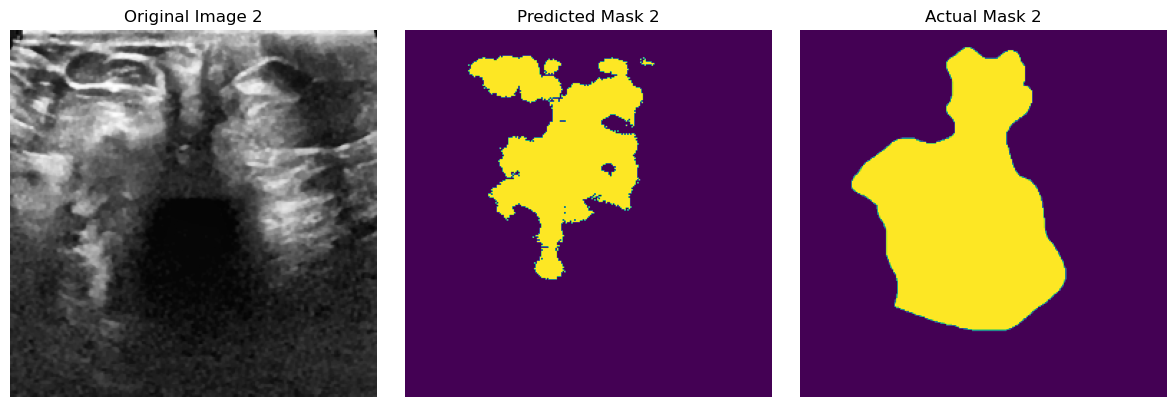

In [20]:
def plot_sample(image, predicted_mask, actual_mask, index):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image)
    ax[0].set_title(f'Original Image {index}')
    ax[0].axis('off')

    ax[1].imshow(predicted_mask, cmap='viridis')
    ax[1].set_title(f'Predicted Mask {index}')
    ax[1].axis('off')

    ax[2].imshow(actual_mask, cmap='viridis')
    ax[2].set_title(f'Actual Mask {index}')
    ax[2].axis('off')
    plt.tight_layout()
    plt.show()

predictions = model_seg.predict(X_val_seg)
predictions = (predictions > 0.5).astype(np.uint8)

for i in range(3):
    plot_sample(X_val_seg[i], predictions[i].squeeze(), y_val_seg[i].squeeze(), i)

## Comparação de resultados

In [21]:
def compare_preprocessing_results():
    # Carrega uma imagem de exemplo
    sample_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
    original_img = cv2.imread(sample_path)
    
    # Pré-processamento original (sem pipeline)
    original_processed = cv2.resize(original_img, (224, 224)) / 255.0
    
    # Pré-processamento com pipeline
    pipeline_processed = preprocessor.preprocess_for_classification(original_img)
    
    # Visualização comparativa
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Imagem Original')
    axes[0].axis('off')
    
    axes[1].imshow(original_processed)
    axes[1].set_title('Pré-processamento Original')
    axes[1].axis('off')
    
    axes[2].imshow(pipeline_processed, cmap='gray')
    axes[2].set_title('Pré-processamento com Pipeline')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Comparação de pré-processamento concluída!")

## Avaliação de diferentes configurações de pré-processamento

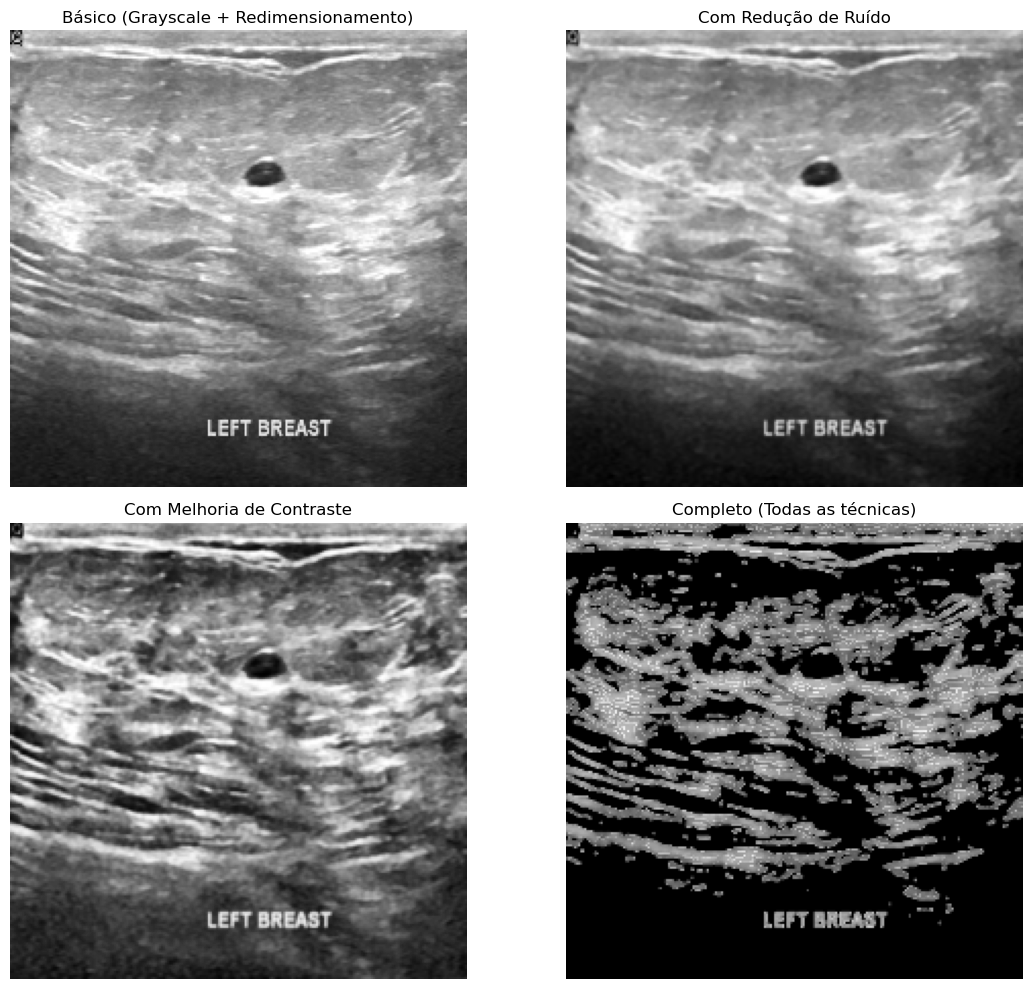

🔍 Avaliação de configurações concluída!


In [22]:
def evaluate_preprocessing_configurations():
    # Carrega uma imagem de exemplo
    sample_path = 'breast_ultrasound_dataset/Dataset_BUSI_with_GT/benign/benign (1).png'
    original_img = cv2.imread(sample_path)
    
    # Configurações diferentes
    configs = [
        {
            'name': 'Básico (Grayscale + Redimensionamento)',
            'params': {'apply_grayscale': True, 'apply_noise_reduction': False, 
                      'apply_contrast': False, 'apply_background_removal': False}
        },
        {
            'name': 'Com Redução de Ruído',
            'params': {'apply_grayscale': True, 'apply_noise_reduction': True, 
                      'apply_contrast': False, 'apply_background_removal': False}
        },
        {
            'name': 'Com Melhoria de Contraste',
            'params': {'apply_grayscale': True, 'apply_noise_reduction': True, 
                      'apply_contrast': True, 'apply_background_removal': False}
        },
        {
            'name': 'Completo (Todas as técnicas)',
            'params': {'apply_grayscale': True, 'apply_noise_reduction': True, 
                      'apply_contrast': True, 'apply_background_removal': True, 
                      'apply_edge_detection': True}
        }
    ]
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, config in enumerate(configs):
        processed = preprocessor.preprocess_for_classification(original_img, **config['params'])
        axes[i].imshow(processed, cmap='gray')
        axes[i].set_title(config['name'])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🔍 Avaliação de configurações concluída!")

# Executa a avaliação
evaluate_preprocessing_configurations()